<a href="https://colab.research.google.com/github/StephenJohnson-CardiffUni/Astro/blob/main/GalaxiesAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress

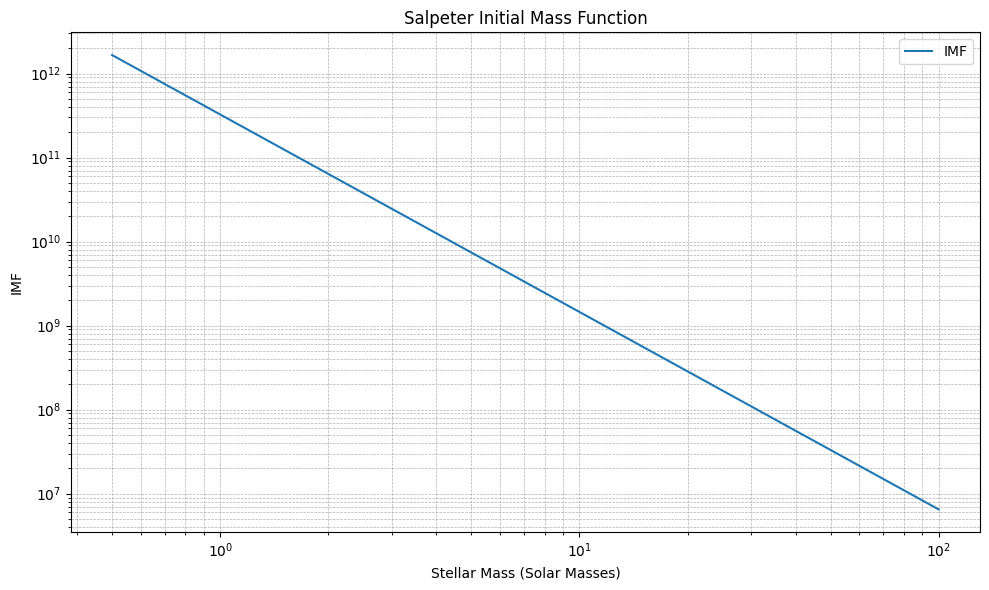

In [40]:
#Constants
SolarLumin = 3.828e26  # Solar luminosity in watts
SolarM = 2e30  # Solar mass in kilograms
Salpeter = 2.35
initialMass = 10e11 #Mass of Cloud in SolarMasses
galaxyLifetime = 12e9 #LifeTime in Years

# Assuming a lower limit of 0.5 solar masses and an upper limit of some solar masses
StarMassMin = 0.5
StarMassMax = 100

#Star Formation Rate
SFR = initialMass / 1e9


def luminosity_func(M): #Takes mass in SolarM, returns in solar luminosities
  return (M)**3.9

def lifeTime_func(M): #Take Mass in SolarM, returns lifetime on main sequence
  return 10e9 * (M)**-2.5

def Mcrit(t): #Takes time in years, returns mass of stars whos life time is equal to this (the ones just dying in a galaxy t old)
  return (10e9/t)**1/2.5

def IMFconst(MassTot):#function to find the IMF constant
  return MassTot / (quad(IMFintegrand,StarMassMin,StarMassMax)[0])

def IMFintegrand(m):#needed for the constant
  return m**-1.35

def IMF(M):#Gives distribution of masses from a cloud of certain size
  return IMFconst(initialMass) * (M)**-Salpeter


massBins = 300
masses = np.linspace(StarMassMin, StarMassMax, num=massBins) #TestMasses for Graphing
massBinWidth = sum(masses)/massBins

IMFvals = IMF(masses) # Mass Dristribution

lumsByMass = IMFvals*luminosity_func(masses) # IMF*luminositys | In Solar Lumins

#Plot the Initial Mass Function and lumins By mass FOR SANITY CHECK
# Plot the Initial Mass Function (IMF) with improved formatting
plt.figure(figsize=(10, 6))
plt.plot(masses, IMFvals, label='IMF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('IMF')
plt.title('Salpeter Initial Mass Function')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# # Plot Luminosity by Mass with improved formatting
# plt.figure(figsize=(10, 6))
# plt.plot(masses, lumsByMass, label='Luminosity')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Stellar Mass (Solar Masses)')
# plt.ylabel('Luminosity')
# plt.title('Luminosity by Mass')
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

In [42]:

timeSteps = 100
SFR = initialMass / 1e9 #mass turned into stars per t

timeArray = np.geomspace(1,12e9,num=timeSteps)

StarsBorn = np.zeros((timeSteps,len(masses)))
StarsAlive = np.zeros((timeSteps,len(masses)))

#life time for stars at masses, tell us how much to add up
lifeTimes = lifeTime_func(masses)

for i, t in enumerate(timeArray):
  #At each time setp - add more stars to born list if still forming, starsborn = mass that slice,
  if t < 1e9:
    StarsBorn[i] = IMF(masses) * (SFR * (t - timeArray[i-1]))

  for j, m in enumerate(masses):
    #look back in born list (t - lifeTime) and add up numbers for that many preceding steps

    #t-lifetime to find earliest birthday of the stars that are dying in this mass range
    runningLifetime = t - lifeTime_func(m)
    #find index for the birthday
    if runningLifetime > 0:
      youngestIndex = np.searchsorted(timeArray, runningLifetime, side='right') - 1
    else:
      youngestIndex = 0
    #need for all elements of StarsBorn[(birthday->today),m]
    for ln in range(youngestIndex,i,1):
      StarsAlive[i,j] = StarsAlive[i,j] + StarsBorn[ln,j]
    # StarsAlive[i,j] = StarsBorn[youngestIndex,j] # + youngestIndex+1,j ... + i,j

In [43]:
from math import isnan

stepLums = np.zeros_like(timeArray)
stepMass = np.zeros_like(timeArray)


for i,t in enumerate(timeArray):
  for j,m in enumerate(masses):
    stepLums[i] = luminosity_func(sum(StarsBorn[i] * m))
    if isnan(stepLums[i]):
      stepLums[i] = 0

    #for my curiosity
    stepMass[i] = sum(StarsBorn[i])
    if isnan(stepMass[i]):
      stepMass[i] = 0

<ipython-input-40-b89505ded24e>:17: RuntimeWarning: invalid value encountered in scalar power
  return (M)**3.9


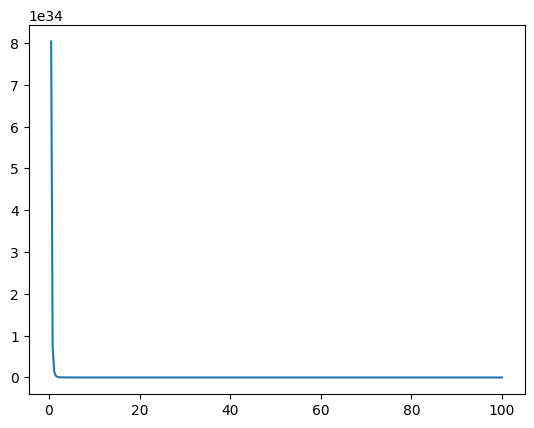

In [47]:
plt.plot(masses,IMFvals*StarsBorn[80])


In [35]:
print(sum(stepMass))

-3.1873928142478735e+25


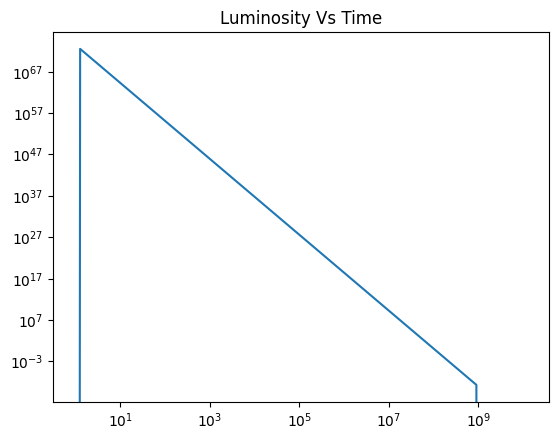

In [27]:
plt.plot(timeArray,stepLums)
plt.title('Luminosity Vs Time')
plt.xscale('log')
plt.yscale('log')

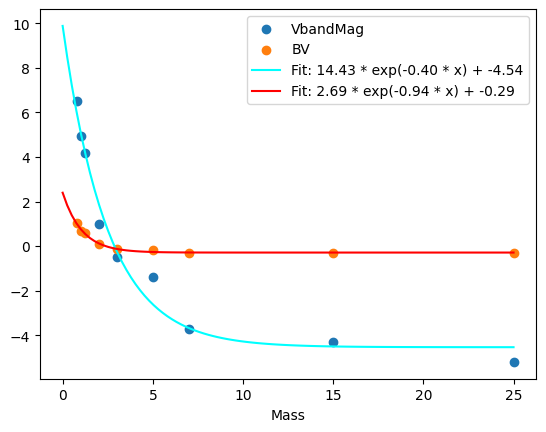

In [13]:
# Data
MagMass = np.array([0.8, 1.0, 1.25, 2, 3, 5, 7, 15, 25])
Mags = np.array([6.5, 4.93, 4.2, 1.0, -0.5, -1.4, -3.7, -4.3, -5.2])
BV = np.array([1.02, 0.69, 0.59, 0.1, -0.12, -0.18, -0.3, -0.32, -0.32])


# Define modified exponential decay model function with offset
def exp_decay(x, a, b, offset):
    return a * np.exp(-b * x) + offset

# Perform curve fitting
poptMag, pcovMag = curve_fit(exp_decay, MagMass, Mags, p0 = ([200,2,100]))
poptBV, pcovBV = curve_fit(exp_decay, MagMass, BV)

# Get fitted parameters
a_fitMag, b_fitMag, offset_fitMag = poptMag
a_fitBV, b_fitBV, offset_fitBV = poptBV

# Plot data and fitted curve
plt.scatter(MagMass, Mags, label='VbandMag')
plt.scatter(MagMass, BV, label='BV')
plt.plot(np.linspace(0,25,100), exp_decay(np.linspace(0,25,100), a_fitMag, b_fitMag, offset_fitMag), color='cyan', label='Fit: {:.2f} * exp(-{:.2f} * x) + {:.2f}'.format(a_fitMag, b_fitMag, offset_fitMag))
plt.plot(np.linspace(0,25,100), exp_decay(np.linspace(0,25,100), a_fitBV, b_fitBV, offset_fitBV), color='red', label='Fit: {:.2f} * exp(-{:.2f} * x) + {:.2f}'.format(a_fitBV, b_fitBV, offset_fitBV))
plt.xlabel('Mass')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


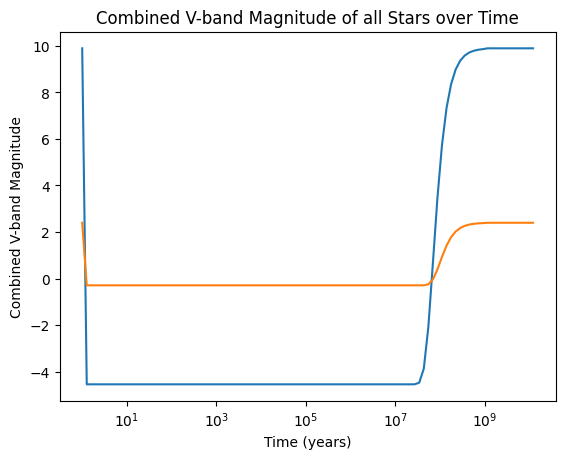

In [8]:
def mass_vmag(mass):
    return exp_decay(mass, a_fitMag, b_fitMag, offset_fitMag)

def mass_BV(mass):
    return exp_decay(mass, a_fitBV, b_fitBV, offset_fitBV)

# Plot combined V-band magnitude versus time
plt.plot(timeArray, mass_vmag(stepMass))
plt.plot(timeArray, mass_BV(stepMass))
plt.xlabel('Time (years)')
plt.ylabel('Combined V-band Magnitude')
plt.title('Combined V-band Magnitude of all Stars over Time')
plt.xscale('log')
# plt.yscale('log')
plt.show()